## Introduction
* **Note:** Turn on your **GPU**.
* In this kernel we will generate new bird sounds using **simple GANs**.

### If you do not know **simple GANs** you can check this kernel:

<div class="row">
  <div class="col-sm-4">
    <div class="card">
      <div class="card-body" style="width: 30rem;">
         <h5 class="card-title"><u>Fashion Dataset GANs</u></h5>
         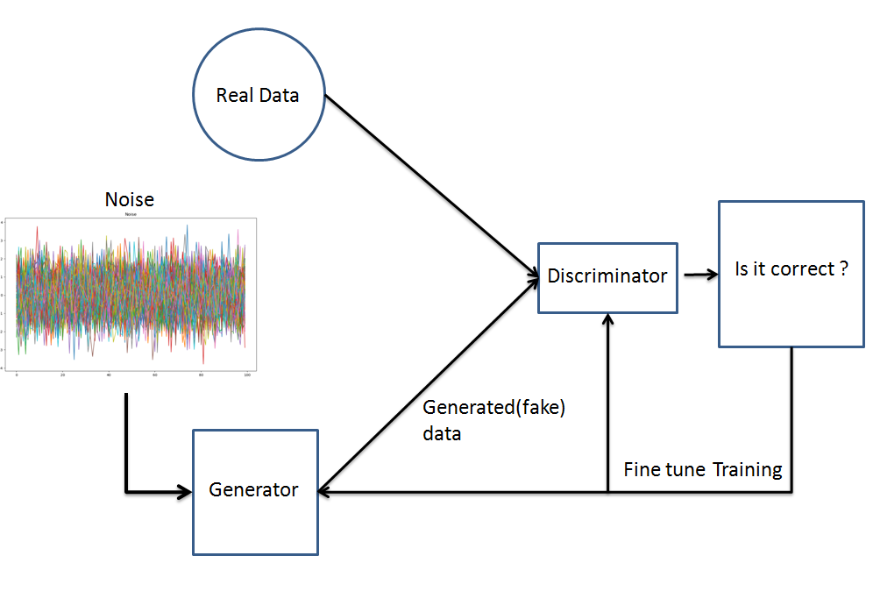<br>
         <p class="card-text">A kernel about generating clothes using traditional GANs</p>
         <a href="https://www.kaggle.com/mrhippo/fashion-dataset-gans" class="btn btn-primary" style="color:white;">Go to Post</a>
      </div>
    </div>
  </div> 
</div>


<hr>

## Content
* We are using [Cornell Birdcall Identification](https://www.kaggle.com/c/birdsong-recognition) dataset.

* [Imports](#1)
* [Data Analysis](#2)
* [Audio Generation with GANs](#3)
    * [Preparing Data](#3.1)
    * [Generator](#3.2)
    * [Discriminator](#3.3)
    * [GANs](#3.4)
    * [Training](#3.5)
    * [Results](#3.6)
* [Conclusion](#4)

<a id="1"></a> <br>
# Imports 

In [ ]:
# data science
import numpy as np 
import pandas as pd 
import librosa
import matplotlib.pyplot as plt
import IPython
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')
import glob
import time

# keras (gan)
from keras.layers import Dense, Dropout, Input, ReLU
from keras.models import Model, Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras import models

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

<a id="2"></a> <br>
# Data Analysis

In [ ]:
_, sr = librosa.load("/kaggle/input/birdsong-recognition/example_test_audio/ORANGE-7-CAP_20190606_093000.pt623.mp3")
sr

In [ ]:
data = []

for path in glob.glob("../input/birdsong-recognition/train_audio/aldfly/*"):
    file, _ = librosa.core.load(path, sr=sr)
    data.append(file)
    
data = np.array(data)

In [ ]:
audio_samples = [data[0], data[2], data[10], data[20], data[42], data[50]] 

for audio in audio_samples:
        IPython.display.display(ipd.Audio(data = audio, rate = sr))

In [ ]:
length_of_audio_samples = len(audio_samples)
fig, ax = plt.subplots(int(length_of_audio_samples/2),2, figsize = (16,length_of_audio_samples*3)) 
    
# drwing plots
count = 0
for r in range(0,int(length_of_audio_samples/2)):
    for c in range(0,2):
        sample = audio_samples[count]
        ax[r,c].plot(sample)
        count += 1
        ax[r,c].set_xlabel("Samples")
        
fig.suptitle("Audio Samples", fontsize = 17)
plt.show()

In [ ]:
length_of_audio_samples = len(audio_samples)
fig, ax = plt.subplots(int(length_of_audio_samples/2),2, figsize = (16,length_of_audio_samples*3)) 
    
# drwing plots
count = 0
for r in range(0,int(length_of_audio_samples/2)):
    for c in range(0,2):
        sample = audio_samples[count]
        ax[r,c].plot(sample[:500])
        ax[r,c].plot(sample[:500], ".", color = "red")
        count += 1
        ax[r,c].set_xlabel("Audio Samples")
        
fig.suptitle("zoomed Audio Samples", fontsize = 17)
plt.show()

In [ ]:
length_of_audio_samples = len(audio_samples)
fig, ax = plt.subplots(int(length_of_audio_samples/2),2, figsize = (16,length_of_audio_samples*3)) 
    
# drwing plots
count = 0
for r in range(0,int(length_of_audio_samples/2)):
    for c in range(0,2):
        sample = audio_samples[count]
        fft = np.fft.fft(sample)

        magnitude = np.abs(fft)
        freq = np.linspace(0, sr, len(magnitude))

        left_freq = freq[:int(len(freq)/2)]
        left_magnitude = magnitude[:int(len(magnitude)/2)]

        ax[r,c].plot(left_freq, left_magnitude)
        ax[r,c].set_xlabel("Frequency")
        ax[r,c].set_ylabel("Magnitude")        
        count += 1

fig.suptitle("FFTs of Audio Samples ", fontsize = 17)
plt.show()

<a id="3"></a> <br>
# Audio Generation with GANs

<a id="3.1"></a> <br>
## Preparing Data

In [ ]:
PATH = "../input/birdsong-recognition/train_audio/"
BIRD = "aldfly"
SR = 22050

def load_data_gan(path, bird, sr, length = 6):
    data = []

    for path in glob.glob(path + bird + "/*"):
        file, _ = librosa.core.load(path, sr=sr)
        
        # all files must be at the same length
        if len(file) > sr*length:
            data.append(file[:sr*length])
            
        else:
            continue

    return np.array(data)

def normalization(X):
    mean = X.mean(keepdims=True)
    std = X.std(keepdims=True)
    X = (X - mean) / std
    print("Data Normalized...")
    return X

def rescale(X, rangeMin=-1, rangeMax=+1):
    maxi = X.max()
    mini = X.min()
    X = np.interp(X, (mini, maxi), (rangeMin, rangeMax))
    print("Data Rescaled...")
    return X

In [ ]:
x_train = load_data_gan(PATH, BIRD, SR, 5)

In [ ]:
x_train = normalization(x_train)
x_train = rescale(x_train)

In [ ]:
IPython.display.display(ipd.Audio(data = x_train[50], rate = 22050))

<a id="3.2"></a> <br>
## Generator
* **Our Generator's diagram:**

<img src = "https://i.pinimg.com/564x/ce/86/2f/ce862fb7c0e96cd891aef482c11dff73.jpg" />

In [ ]:
def create_generator():
    
    generator = Sequential()
    generator.add(Dense(units = 512, input_dim = 100))
    generator.add(ReLU())
    
    generator.add(Dense(units = 512))
    generator.add(ReLU())
    
    generator.add(Dense(units = 1024))
    generator.add(ReLU())
    
    generator.add(Dense(units = 1024))
    generator.add(ReLU())
    
    generator.add(Dense(units = x_train.shape[1]))
    
    generator.compile(loss ="binary_crossentropy",
                     optimizer = Adam(lr = 0.0001, beta_1 = 0.5))
    
    return generator

g = create_generator()
g.summary()

<a id="3.3"></a> <br>
## Discriminator
* **Our Discriminator's diagram:**

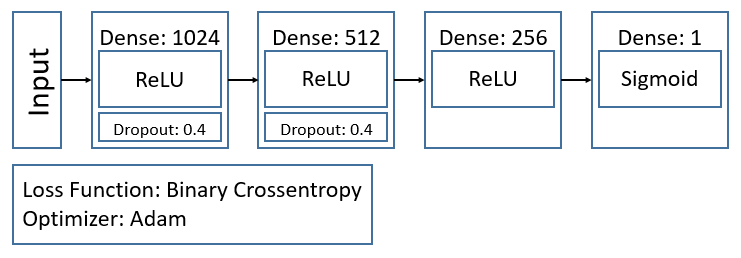

In [ ]:
def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Dense(units = 1024,input_dim = x_train.shape[1])) 
    discriminator.add(ReLU())
    discriminator.add(Dropout(0.4))
    
    discriminator.add(Dense(units = 512)) 
    discriminator.add(ReLU())
    discriminator.add(Dropout(0.4))
    
    discriminator.add(Dense(units = 256)) 
    discriminator.add(ReLU())
    
    discriminator.add(Dense(units = 1, activation = "sigmoid"))
    
    discriminator.compile(loss = "binary_crossentropy",
                         optimizer = Adam(lr = 0.0001, beta_1 = 0.5))
    return discriminator

d = create_discriminator()
d.summary()

<a id="3.4"></a> <br>
## GANs
* **Our Simple GANs' diagram:**

<img src = "https://i.pinimg.com/564x/ad/0f/21/ad0f213fed7e0497583ca3bdc03b3c1a.jpg" />

In [ ]:
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs = gan_input, outputs = gan_output)
    gan.compile(loss = "binary_crossentropy", optimizer = "adam")
    return gan

gan = create_gan(d,g)
gan.summary()

<a id="3.5"></a> <br>
## Training
* In trainig each epoch is a round between Generator and Discriminator. First we are giving a noise to our Generator. Then giving real data and generated data to Discriminator labeling real data as 1 generated as 0. After that we are turning off trainable parameter of Discriminator, generating new audios and labeling them as 1 and train GANs on these audios.
* **Our training diagram:**

In [ ]:
def show_gen_samples(epochs, samples = 3):
    samplePlot = []
    fig        = plt.figure(figsize = (1, samples))
    noise      = np.random.normal(0, 1, (samples,100))
    audios     = g.predict(noise)        
    for i, audio in enumerate(audios):
        IPython.display.display(ipd.Audio(data = audio, rate = SR))
        samplePlot.append(fig.add_subplot(1, samples, i+1))
        samplePlot[i].plot(audio.flatten(), '-', )
    plt.gcf().set_size_inches(25, 5)
    plt.subplots_adjust(wspace=0.3,hspace=0.3)
    fig.suptitle("{} Epochs Result".format(epochs), fontsize = 17)
    plt.show()

In [ ]:
import time

D_loss = []
G_loss = []
epochs = 40 
batch_size = 16
current_time = time.time()

for e in range(epochs):
    start_time = time.time()
    for _ in range(batch_size):
        # I reccomend you to look "Training Diagram" (at the top) 
        noise = np.random.normal(0,1, [batch_size,100])
        
        generated_audio = g.predict(noise)
       
        audio_batch = x_train[np.random.randint(low = 0, high = x_train.shape[0], size = batch_size)] #get samples from real data
        
        x = np.concatenate([audio_batch, generated_audio])
        
        y_dis = np.zeros(batch_size*2) 
        y_dis[:batch_size] = 1 # we labeled real audios as 1 and generated audios as 0
        
        d.trainable = True
        d_loss = d.train_on_batch(x,y_dis) # we are training discriminator (train_on_batch)
        
        noise = np.random.normal(0,1,[batch_size,100])
        
        y_gen = np.ones(batch_size) # our generator says "these audios are real"
        
        d.trainable = False
        
        g_loss = gan.train_on_batch(noise, y_gen) #train_on_batch
        
        D_loss.append(d_loss)
        G_loss.append(g_loss)
        
    if (e%2 == 0) or (e == epochs-1) :
        print("epochs: ",e)
    if e == epochs-1:
        print("Time since start: {}".format(np.round(start_time - current_time)))
        print("Training Complete.")
    
    # printing results
    if e%10 == 0:
        print("Time since start: {}".format(np.round(start_time - current_time)))
        show_gen_samples(e)

In [ ]:
g.save("bird_sound_generator.h5") # you can donwload this model from output part of this kernel.
d.save("bird_sound_discriminator.h5") # you can donwload this model from output part of this kernel.

<a id="3.6"></a> <br>
## Results

In [ ]:
index = 0
D_loss2 = []
G_loss2 = []

for i in range(1,epochs+1):
    D_loss2.append(D_loss[index])
    G_loss2.append(G_loss[index])
    index += batch_size

fig, axs = plt.subplots(2, 1, figsize = (12,10))

axs[0].plot(D_loss2, label = "Discriminator Loss")
axs[1].plot(G_loss2, label = "Generator Loss", color = "orange")

axs[0].set_xlabel("Epochs")
axs[1].set_xlabel("Epochs")

axs[0].set_ylabel("Loss")
axs[1].set_ylabel("Loss")

axs[0].set_title("Discriminator Loss")
axs[1].set_title("Generator Loss")
plt.show()

In [ ]:
show_gen_samples(epochs = epochs)

<a id="4"></a> <br>
# Conclusion
* **You can download this model from Output part of the kernel.**

### You can check my other kernels here: https://www.kaggle.com/mrhippo/notebooks

* **My other GANs projects**:
* https://www.kaggle.com/mrhippo/fashion-dataset-gans
* https://www.kaggle.com/mrhippo/abstract-art-dcgans
* https://www.kaggle.com/mrhippo/audio-generation-with-simple-gans


* **If there is something wrong with this kernel please let me know in the comments.**


* **References:**
* https://github.com/rafalencar1997/Audio_Generation